In [1]:
import pandas as pd
import random
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, BertConfig, BertModel
import adapters
from adapters import AutoAdapterModel
import gc
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib

import pickle
import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [2]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import (
    fix_all_seeds,
    train_loop,
    train_loop_batches_eval,
    train_loop_train_test_split,
)
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)
from text_embeddings_src.metrics import knn_accuracy

In [3]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [4]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [5]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [6]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [ ]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers -p openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-11-28 09:01:11CET

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.28.0

openTSNE: 1.0.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.18.0-553.el8_10.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

pandas             : 2.2.3
torch              : 2.5.0
jupyter_black      : 0.4.0
sklearn            : 1.5.2
text_embeddings_src: 0.0.0
matplotlib         : 3.9.2
transformers       : 4.45.2
adapters           : 1.0.1
memory_profiler    : 0.61.0
black              : 24.10.0
numpy              : 1.26.4
distro             : 1.9.0

Watermark: 2.5.0

Ubuntu 24.04 LTS


# Import

In [8]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    engine="pyarrow",
)

CPU times: user 259 ms, sys: 77.3 ms, total: 337 ms
Wall time: 363 ms


In [9]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [ ]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [11]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

# Basic run + eval kNN accuracy

## Optimize [AV]
Training run1:

Optimize the [av] representation for 2 epochs for all models. batch_size=64, lr=2e-5.

Data augmentation (MultSentencesPairDataset), with n_cons_sntcs=2.

### All models

In [1]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    "allenai/specter2_base",
]

In [21]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    if model_name == "SPECTER2":
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoAdapterModel.from_pretrained(model_paths[i])
        print(model_paths[i])
        # add adapter proximity
        model.load_adapter(
            "allenai/specter2",
            source="hf",
            load_as="specter2",
            set_active=True,
        )

    else:
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=2,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(parents=True, exist_ok=True)

    np.save(variables_path / saving_path / "losses_run1", losses)
    np.save(
        variables_path / saving_path / "knn_accuracies_run1",
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SimCSE
Running on device: cuda
princeton-nlp/unsup-simcse-bert-base-uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR
Running on device: cuda
johngiorgi/declutr-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR-sci
Running on device: cuda
johngiorgi/declutr-sci-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SPECTER2
Running on device: cuda


OSError: allenai/specter2-base is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

#### Plot

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

In [ ]:
colormap = plt.get_cmap("tab10")
dict_original_colors = dict()
for i, model_name in enumerate(model_names):
    color = colormap(i)
    dict_original_colors[model_name] = colormap(i)

In [ ]:
# new order
model_names = [
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

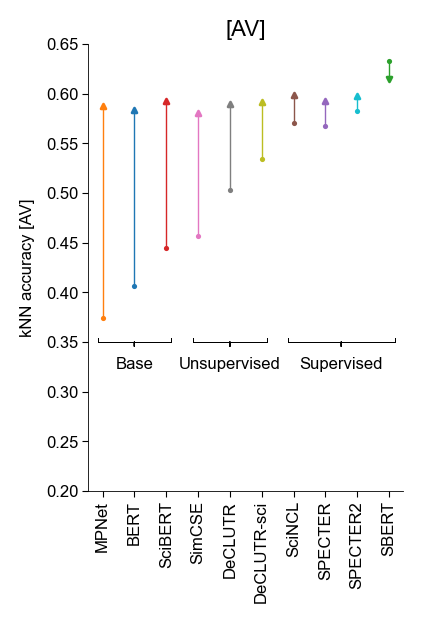

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)

rep = 0  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = dict_original_colors[model_name]

    ax.plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    ax.scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [AV]")
    # ax.legend(loc="lower right")
    ax.set_title("[AV]")
    ax.annotate(
        "Base",
        xy=(1, 0.35),
        xytext=(1, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ax.annotate(
        "Unsupervised",
        xy=(4, 0.35),
        xytext=(4, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ax.annotate(
        "Supervised",
        xy=(7.5, 0.35),
        xytext=(7.5, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=3.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )


fig.savefig(figures_path / "loss_and_knn_accuracy_training_run1_fancy3_v3.png")

#### Rebuttal: Add BGE BAAI

In [12]:
model_names = [
    "BGE",
]


model_paths = [
    "BAAI/llm-embedder",
]

In [13]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    if model_name == "SPECTER2":
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoAdapterModel.from_pretrained(model_paths[i])
        print(model_paths[i])
        # add adapter proximity
        model.load_adapter(
            "allenai/specter2",
            source="hf",
            load_as="specter2",
            set_active=True,
        )

    else:
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(parents=True, exist_ok=True)

    np.save(variables_path / saving_path / "losses_run1", losses)
    np.save(
        variables_path / saving_path / "knn_accuracies_run1",
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  BGE
Running on device: cuda


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BAAI/llm-embedder


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------
CPU times: user 9min 37s, sys: 1min 21s, total: 10min 59s
Wall time: 7min 49s


In [14]:
print(knn_accuracies)

[array([0.62692308, 0.58230769, 0.61538462])]


#### Training only on train set
Only MPNet, standard training setting

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool, sep_pool, cls_pool
from text_embeddings_src.embeddings import generate_embeddings


# function to move to model_stuff
def train_loop_train_test_split(
    model,
    loader,
    device,
    tokenizer,
    abstracts_eval_train,
    abstracts_eval_test,
    labels_eval_train,
    labels_eval_test,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
):
    assert optimized_rep in [
        "av",
        "cls",
        "sep",
        "7th",
    ], "Not valid `optimized_rep`. Choose from ['av', 'cls', 'sep', '7th']."

    model.to(device)

    # define layers to be used in multiple-negatives-ranking
    cos_sim = torch.nn.CosineSimilarity()
    loss_func = torch.nn.CrossEntropyLoss()
    scale = 20.0  # we multiply similarity score by this scale value, it is the inverse of the temperature
    # move layers to device
    cos_sim.to(device)
    loss_func.to(device)

    # initialize Adam optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # setup warmup for first ~10% of steps
    total_steps = len(loader) * n_epochs
    warmup_steps = int(0.1 * len(loader))
    scheduler = get_linear_schedule_with_warmup(
        optim,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    losses = np.empty((n_epochs, len(loader)))
    accuracies = []
    for epoch in range(n_epochs):
        model.train()  # make sure model is in training mode
        # initialize the dataloader loop with tqdm (tqdm == progress bar)
        loop = tqdm(loader, leave=True)
        for i_batch, batch in enumerate(loop):
            # zero all gradients on each new step
            optim.zero_grad()
            # prepare batches and move all to the active device
            anchor_ids = batch[0][0].to(
                device
            )  # this are all anchor abstracts from the batch,len(anchor_ids)= len(batch)
            anchor_mask = batch[0][1].to(device)
            pos_ids = batch[1][0].to(
                device
            )  # this each positive pair from each anchor, all in one array, also len(batch)
            pos_mask = batch[1][1].to(device)
            # extract token embeddings from BERT
            a = model(anchor_ids, attention_mask=anchor_mask)[
                0
            ]  # all token embeddings
            p = model(pos_ids, attention_mask=pos_mask)[0]

            # get the mean pooled vectors  -- put all of these ifs into a pool function (wraper) to which I pass, a, p the masks and the optimized rep
            if optimized_rep == "av":
                a = mean_pool(a, anchor_mask)
                p = mean_pool(p, pos_mask)

            elif optimized_rep == "cls":
                a = cls_pool(a, anchor_mask)
                p = cls_pool(p, pos_mask)

            elif optimized_rep == "sep":
                a = sep_pool(a, anchor_mask)
                p = sep_pool(p, pos_mask)

            elif optimized_rep == "7th":
                a = seventh_pool(a, anchor_mask)
                p = seventh_pool(p, pos_mask)

            # calculate the cosine similarities
            scores = torch.stack(
                [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
            )
            # get label(s) - we could define this before if confident
            # of consistent batch sizes
            labels = torch.tensor(
                range(len(scores)), dtype=torch.long, device=scores.device
            )  # I think that the labels are just the label of which pair it is. 0 for the first pair, 1 for the second...
            # my guess is that they are used in the loss to know which of the cosine similarities should be high
            # and which low

            # and now calculate the loss
            loss = loss_func(scores * scale, labels)
            losses[epoch, i_batch] = loss.item()

            # using loss, calculate gradients and then optimize
            loss.backward()
            optim.step()
            # update learning rate scheduler
            scheduler.step()
            # update the TDQM progress bar
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(loss=loss.item())

        ## evaluation of the unseen test set for each epoch
        (
            embedding_cls_train,
            embedding_sep_train,
            embedding_av_train,
        ) = generate_embeddings(
            abstracts_eval_train,
            tokenizer,
            model,
            device,
            batch_size=256,
        )

        (
            embedding_cls_test,
            embedding_sep_test,
            embedding_av_test,
        ) = generate_embeddings(
            abstracts_eval_test,
            tokenizer,
            model,
            device,
            batch_size=256,
        )

        knn = KNeighborsClassifier(
            n_neighbors=10, algorithm="brute", n_jobs=-1, metric="euclidean"
        )
        knn = knn.fit(embedding_av_train, labels_eval_train)
        acc = knn.score(embedding_av_test, labels_eval_test)

        accuracies.append(acc)

    return losses, accuracies

In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    # split the data in train and test before dataset and loader
    random_state = np.random.seed(42)
    (
        abstracts_iclr_train,
        abstracts_iclr_test,
        labels_iclr_train,
        labels_iclr_test,
    ) = train_test_split(
        iclr2024.abstract,
        labels_iclr,
        test_size=0.1,
        random_state=random_state,
    )

    # only do a dataset and loader from the training set
    training_dataset = MultOverlappingSentencesPairDataset(
        abstracts_iclr_train, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop_train_test_split(
        model,
        training_loader,
        device,
        tokenizer,
        abstracts_iclr_train[labels_iclr_train != "unlabeled"].to_list(),
        abstracts_iclr_test[labels_iclr_test != "unlabeled"].to_list(),
        labels_iclr_train[labels_iclr_train != "unlabeled"],
        labels_iclr_test[labels_iclr_test != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(parents=True, exist_ok=True)

    np.save(
        variables_path / saving_path / "losses_run1_train_test_split", losses
    )
    np.save(
        variables_path / saving_path / "knn_accuracies_run1_train_test_split",
        knn_accuracies,
    )

    # # clean up
    # model = None
    # tokenizer = None_train_test_split
    # gc.collect()
    # torch.cuda.empty_cache()

    print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

----------------------------
CPU times: user 10min 21s, sys: 1min 30s, total: 11min 51s
Wall time: 6min 34s


In [ ]:
print(knn_accuracies)

[0.5677321156773212]


##### Sanity check
Rerun the basic running, training again in the whole dataset

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    # split the data in train and test before dataset and loader
    random_state = np.random.seed(42)
    (
        abstracts_iclr_train,
        abstracts_iclr_test,
        labels_iclr_train,
        labels_iclr_test,
    ) = train_test_split(
        iclr2024.abstract,
        labels_iclr,
        test_size=0.1,
        random_state=random_state,
    )

    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop_train_test_split(
        model,
        training_loader,
        device,
        tokenizer,
        abstracts_iclr_train[labels_iclr_train != "unlabeled"].to_list(),
        abstracts_iclr_test[labels_iclr_test != "unlabeled"].to_list(),
        labels_iclr_train[labels_iclr_train != "unlabeled"],
        labels_iclr_test[labels_iclr_test != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(parents=True, exist_ok=True)

    np.save(
        variables_path
        / saving_path
        / "losses_run1_train_test_split_sanity_check",
        losses,
    )
    np.save(
        variables_path
        / saving_path
        / "knn_accuracies_run1_train_test_split_sanity_check",
        knn_accuracies,
    )

    # # clean up
    # model = None
    # tokenizer = None_train_test_split
    # gc.collect()
    # torch.cuda.empty_cache()

    print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

----------------------------
CPU times: user 11min 15s, sys: 1min 23s, total: 12min 39s
Wall time: 7min 4s


In [ ]:
print(knn_accuracies)

[0.5791476407914764]


##### Sanity check (II)

In [ ]:
model_names = [
    # "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
    # "SimCSE",
    # "DeCLUTR",
    # "DeCLUTR-sci",
    # "SPECTER2",
]


model_paths = [
    # "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
    # "princeton-nlp/unsup-simcse-bert-base-uncased",
    # "johngiorgi/declutr-base",
    # "johngiorgi/declutr-sci-base",
    # "allenai/specter2_base",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    if model_name == "SPECTER2":
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoAdapterModel.from_pretrained(model_paths[i])
        print(model_paths[i])
        # add adapter proximity
        model.load_adapter(
            "allenai/specter2",
            source="hf",
            load_as="specter2",
            set_active=True,
        )

    else:
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=2,
        lr=2e-5,
    )

    # # save
    # saving_path = Path("embeddings_" + model_name.lower()) / Path(
    #     "updated_dataset"
    # )
    # (variables_path / saving_path).mkdir(parents=True, exist_ok=True)

    # np.save(variables_path / saving_path / "losses_run1", losses)
    # np.save(
    #     variables_path / saving_path / "knn_accuracies_run1",
    #     knn_accuracies,
    # )

    # # clean up
    # model = None
    # tokenizer = None
    # gc.collect()
    # torch.cuda.empty_cache()

    print(knn_accuracies)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

[array([0.58769231, 0.51615385, 0.54769231]), array([0.58846154, 0.53076923, 0.55615385])]
CPU times: user 26min 8s, sys: 2min 40s, total: 28min 49s
Wall time: 17min 15s


In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    if model_name == "SPECTER2":
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoAdapterModel.from_pretrained(model_paths[i])
        print(model_paths[i])
        # add adapter proximity
        model.load_adapter(
            "allenai/specter2",
            source="hf",
            load_as="specter2",
            set_active=True,
        )

    else:
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=2e-5,
    )

    # # save
    # saving_path = Path("embeddings_" + model_name.lower()) / Path(
    #     "updated_dataset"
    # )
    # (variables_path / saving_path).mkdir(parents=True, exist_ok=True)

    # np.save(variables_path / saving_path / "losses_run1", losses)
    # np.save(
    #     variables_path / saving_path / "knn_accuracies_run1",
    #     knn_accuracies,
    # )

    # # clean up
    # model = None
    # tokenizer = None
    # gc.collect()
    # torch.cuda.empty_cache()

    print(knn_accuracies)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

[array([0.58769231, 0.51230769, 0.54615385])]
CPU times: user 13min 28s, sys: 1min 29s, total: 14min 58s
Wall time: 8min 40s


### Random BERT

In [ ]:
%%time
model_name = "random_bert"

# fix random seeds
fix_all_seeds()

# set up model
print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)

# clean up
model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache()

print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

#### Training only on the train set
Random BERT, standard training setting

In [12]:
%%time
model_name = "random_bert"

# fix random seeds
fix_all_seeds()

# set up model
print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config


# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    abstracts_iclr_train,
    abstracts_iclr_test,
    labels_iclr_train,
    labels_iclr_test,
) = train_test_split(
    iclr2024.abstract,
    labels_iclr,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    abstracts_iclr_train, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split(
    model,
    training_loader,
    device,
    tokenizer,
    abstracts_iclr_train[labels_iclr_train != "unlabeled"].to_list(),
    abstracts_iclr_test[labels_iclr_test != "unlabeled"].to_list(),
    labels_iclr_train[labels_iclr_train != "unlabeled"],
    labels_iclr_test[labels_iclr_test != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run1_train_test_split", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1_train_test_split",
    knn_accuracies,
)

# # clean up
# model = None
# tokenizer = None_train_test_split
# gc.collect()
# torch.cuda.empty_cache()

print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

----------------------------
CPU times: user 1h 38s, sys: 7min 21s, total: 1h 7min 59s
Wall time: 57min 5s


### Evaluate after each batch

In [ ]:
%%time
i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_iclr_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 

##### Plot

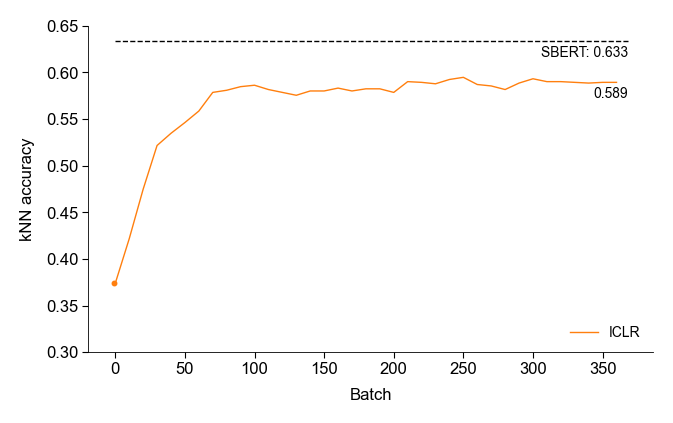

In [ ]:
%matplotlib inline
n_epochs = 2

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200)
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)


ax.plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
    c="tab:orange",
)
ax.text(
    368,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax.hlines(knn_acc_highd_sbert[0], 0, 368, color="k", linestyles="--")
ax.text(
    368,
    knn_acc_highd_sbert[0] - 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax.legend(loc="lower right")
ax.scatter(-1, knn_acc_highd[0], c="tab:orange", s=5)
ax.set_ylim(0.3, 0.65)
ax.set_xlabel("Batch")
ax.set_ylabel("kNN accuracy")

fig.savefig(
    figures_path / "knn_accuracies_MPNet_batches_train_iclr_eval_iclr_v2.png"
)

## Optimize [CLS]
Training run3:

Optimize the [cls] representation for 2 epochs for all models. batch_size=64, lr=2e-5.

Data augmentation (MultSentencesPairDataset), with n_cons_sntcs=2.

### All models

In [28]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    "allenai/specter2_base",
]

In [29]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    if model_name == "SPECTER2":
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoAdapterModel.from_pretrained(model_paths[i])
        print(model_paths[i])
        # add adapter proximity
        model.load_adapter(
            "allenai/specter2",
            source="hf",
            load_as="specter2",
            set_active=True,
        )

    else:
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=2,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(parents=True, exist_ok=True)

    np.save(variables_path / saving_path / "losses_run3", losses)
    np.save(
        variables_path / saving_path / "knn_accuracies_run3",
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SimCSE
Running on device: cuda
princeton-nlp/unsup-simcse-bert-base-uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR
Running on device: cuda
johngiorgi/declutr-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR-sci
Running on device: cuda
johngiorgi/declutr-sci-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SPECTER2
Running on device: cuda
allenai/specter2_base


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 33min 17s, sys: 53min 56s, total: 1h 27min 13s
Wall time: 1h 7min 42s


#### Plot

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

In [ ]:
colormap = plt.get_cmap("tab10")
dict_original_colors = dict()
for i, model_name in enumerate(model_names):
    color = colormap(i)
    dict_original_colors[model_name] = colormap(i)

In [ ]:
# new order
model_names = [
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

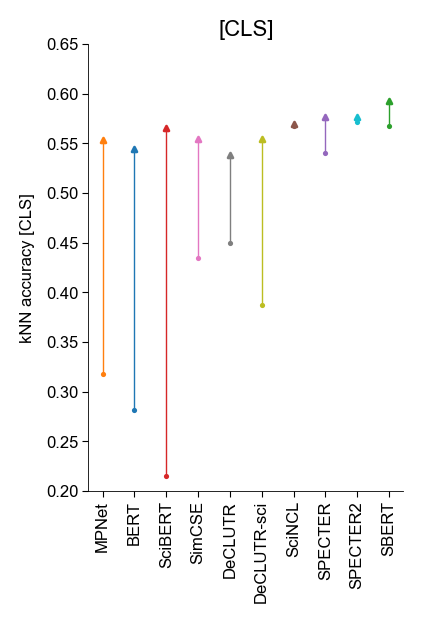

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)
rep = 1

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = dict_original_colors[model_name]

    ax.plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    ax.scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [CLS]")
    # ax.legend(loc="lower right")
    ax.set_title("[CLS]")
    # ax.annotate(
    #     "Base",
    #     xy=(1, 0.35),
    #     xytext=(1, 0.32),
    #     xycoords="data",
    #     fontsize=6,
    #     ha="center",
    #     va="bottom",
    #     bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
    #     arrowprops=dict(
    #         arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
    #     ),
    # )


fig.savefig(figures_path / "loss_and_knn_accuracy_training_run3_fancy3_v3.png")

### Random BERT

In [ ]:
%%time
model_name = "random_bert"

# fix random seeds
fix_all_seeds()

# set up model
print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="cls",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3",
    knn_accuracies,
)

# clean up
model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache()

print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 32min 47s, sys: 1h 6min 57s, total: 1h 39min 44s
Wall time: 1h 24min 10s


##### Plot

[[0.27769231 0.27846154 0.16153846]
 [0.41461538 0.43615385 0.26307692]
 [0.47692308 0.48846154 0.30538462]
 [0.49846154 0.51230769 0.34461538]
 [0.52230769 0.52307692 0.33692308]
 [0.50846154 0.53846154 0.33846154]
 [0.51461538 0.55076923 0.34230769]
 [0.51076923 0.54846154 0.34538462]
 [0.52692308 0.54769231 0.34692308]
 [0.52       0.54923077 0.35307692]]


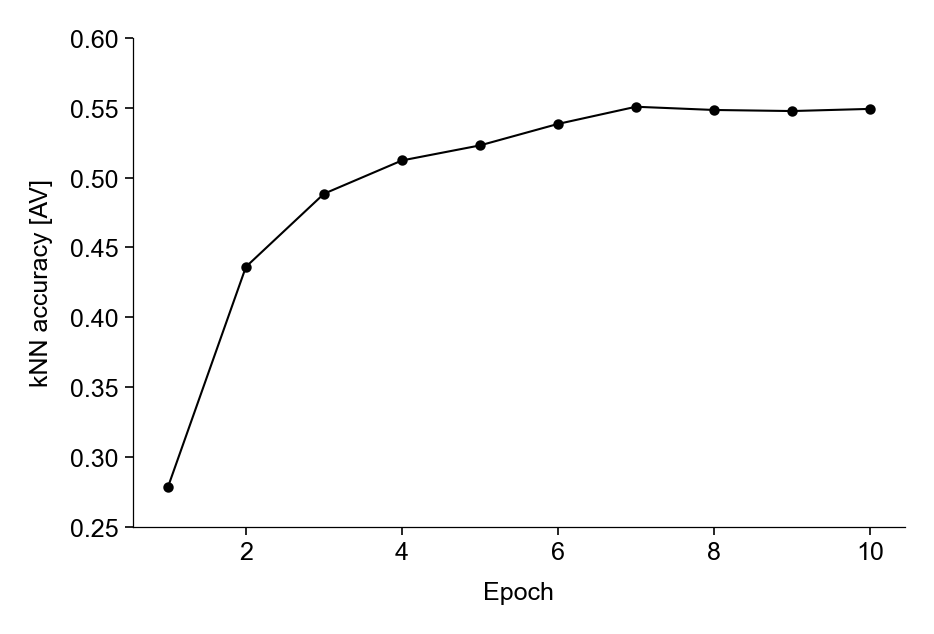

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 2), dpi=300, layout="constrained")

colormap = plt.get_cmap("tab10")
rep = 1  # av
model_name = "random_bert"

# for i, model_name in enumerate(model_names):
# load things
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

losses = np.load(variables_path / saving_path / "losses_run3.npy")
knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run3.npy"
)

saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_accuracies_before = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
print(knn_accuracies_after)

ax.plot(
    np.arange(10) + 1,
    knn_accuracies_after[:, rep],
    # label=f"{model_name}",
    color="k",
    marker=".",
    ms=3,
)

# ax.set_xticks(np.arange(len(model_names)))
# ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylim(0.25, 0.6)
ax.set_ylabel("kNN accuracy [AV]")
ax.set_xlabel("Epoch")
# ax.set_xlim(0.35, 0.6)
# ax.legend(loc="lower right")
# ax.set_title("[AV]")


fig.savefig(
    figures_path / "knn_accuracy_training_run3_with_random_bert_v1.png"
)

# Basic run + eval linear accuracy 

## Optimize [AV]
Training run6
Optimize the [AV] representation for 2 epochs for all models. batch_size=64, lr=2e-5.

Data augmentation (MultOverlappingSentencesPairDataset), with n_cons_sntcs=2

Evaluation: linear accuracy.

### All models

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    "allenai/specter2_base",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    if model_name == "SPECTER2":
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoAdapterModel.from_pretrained(model_paths[i])
        print(model_paths[i])
        # add adapter proximity
        model.load_adapter(
            "allenai/specter2",
            source="hf",
            load_as="specter2",
            set_active=True,
        )

    else:
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )
    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=2,
        lr=2e-5,
        eval_metric="lin",
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_run6", losses)
    np.save(variables_path / saving_path / "linear_accuracy_run6", accuracies)

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  BERT
Running on device: cuda
bert-base-uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SciBERT
Running on device: cuda
allenai/scibert_scivocab_uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SPECTER
Running on device: cuda
allenai/specter


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SciNCL
Running on device: cuda
malteos/scincl


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SimCSE
Running on device: cuda
princeton-nlp/unsup-simcse-bert-base-uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR
Running on device: cuda
johngiorgi/declutr-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR-sci
Running on device: cuda
johngiorgi/declutr-sci-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SPECTER2
Running on device: cuda


NameError: name 'AutoAdapterModel' is not defined

#### Plot

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

In [ ]:
colormap = plt.get_cmap("tab10")
dict_original_colors = dict()
for i, model_name in enumerate(model_names):
    color = colormap(i)
    dict_original_colors[model_name] = colormap(i)

In [ ]:
# new order
model_names = [
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

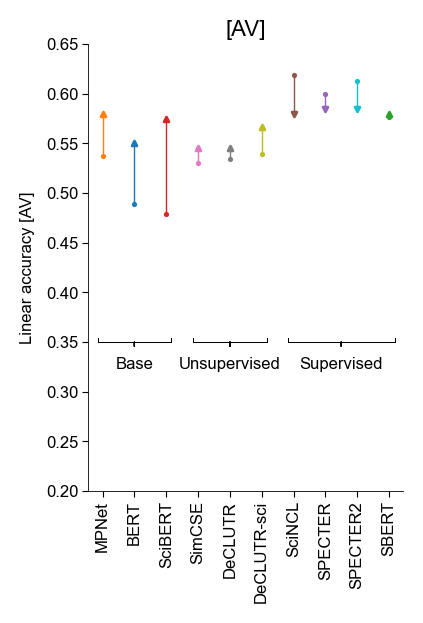

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)

rep = 0  # av
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    losses = np.load(variables_path / saving_path / "losses_run6.npy")
    accuracies_after = np.load(
        variables_path / saving_path / "linear_accuracy_run6.npy"
    )
    accuracy_before = np.load(
        variables_path / saving_path / "linear_accuracy.npy"
    )

    color = dict_original_colors[model_name]  
    ax.plot(
        np.ones(2) * i,
        np.array([accuracy_before[rep], accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,

    )
    ax.scatter(
        i,
        accuracy_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if accuracy_before[rep] <= accuracies_after[0, rep]:
        ax.scatter(
            i,
            accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("Linear accuracy [AV]")

    ax.set_title("[AV]")
    ax.annotate(
        "Base",
        xy=(1, 0.35),
        xytext=(1, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ax.annotate(
        "Unsupervised",
        xy=(4, 0.35),
        xytext=(4, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ax.annotate(
        "Supervised",
        xy=(7.5, 0.35),
        xytext=(7.5, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=3.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

fig.savefig(
    figures_path / "loss_and_linear_accuracy_training_run6_fancy3_v1.png"
)

### Random BERT

In [ ]:
%%time
model_name = "random_bert"

# fix random seeds
fix_all_seeds()

# set up model
print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, accuracies = train_loop(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
    eval_metric="lin",
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run6", losses)
np.save(
    variables_path / saving_path / "linear_accuracy_run6",
    accuracies,
)

# clean up
model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache()

print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

## Optimize [CLS]
Training run2
Optimize the [CLS] representation for 3 epochs for BERT, MPNET, and SBERT. batch_size=64, lr=2e-5.

Data augmentation (MultOverlappingSentencesPairDataset), with n_cons_sntcs=2

Evaluation: linear accuracy.

Note: not included in the paper.

### All models

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))
    
    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )
    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=3,
        lr=2e-5,
        eval_metric= "lin",
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_run2", losses)
    np.save(
        variables_path / saving_path / "linear_accuracy_run2", accuracies
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  BERT
Running on device: cuda
bert-base-uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 